## Install the Packages.
The configuration of necessary libraries to run the project code.

In [ ]:
import os, glob, datetime, time, re
import shutil, random, math
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from prettytable import PrettyTable
from matplotlib import pyplot as plt

import scipy.io
import numpy as np
import seaborn as sns
import plotly.express as px
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.init as init
import torch.nn.functional as F

%matplotlib inline

## Seed Randomness
In order to maintain consistency and reproducibility in our neural network models within the Python environment, we establish a robust control mechanism for randomness. This system is designed to regulate the random seed values across various critical components, including the operating system, the built-in Python 'Random' module, the popular 'Numpy' library, and the 'Pytorch' framework API. By carefully managing these seeds, we can ensure that our neural network experiments yield consistent results, making it easier to track and verify the impact of different parameters and configurations on our models.

In [ ]:
def SEED():
  seed = 123789 # Internation fixed number of seed...
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
  np.random.seed(seed)  # Numpy module.
  random.seed(seed)  # Python random module.
  torch.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  os.environ['PYTHONHASHSEED'] = str(seed)

## Matrix Index
The Matrix Index, as defined in the given context, comprises three key metrics: PSNR (Peak Signal-to-Noise Ratio), SSIM (Structural Similarity Index), and SAM (Spectral Angle Mapper).

> These metrics are used to evaluate and quantify the quality and similarity of HSI data.
- PSNR: Measures the ratio of the peak signal power to the noise power in a HSI samples, making it valuable for assessing HSI image quality.
- SSIM: Evaluates the structural similarity between two HSI images.
- SAM: Calculates the spectral angle between two spectral vectors, often used in remote sensing and image analysis to assess spectral similarity.
  - The SAM algorithm only used the vector direction, not to be vector length.
  - The SAM formula: $a = cos^{-1}(\frac{∑_{i=1}^{nb}t_ir_i}{\sqrt{∑_{i=1}^{nb}t_i^2}\sqrt{∑_{i=1}^{nb}r_i^2}})$
  - a: spectral angle b/w two spectra
  - n: numbers of bands
  - $t_i$: reflectance value of band $i$ in the test spectra
  - $r_i$: reflectance value of band $i$ in the reference spectra

These metrics collectively offer a comprehensive means to assess and compare data quality and similarity.


In [ ]:
SEED()
def sam(x_true, x_pred):
    assert x_true.ndim ==3 and x_true.shape == x_pred.shape
    h,w,c=x_pred.shape
    sam_rad = []
    for x in range(x_true.shape[0]):
        for y in range(x_true.shape[1]):
            tmp_pred = x_pred[x, y].ravel()
            tmp_true = x_true[x, y].ravel()
            s = np.sum(np.dot(tmp_pred, tmp_true))
            t = (np.sqrt(np.sum(tmp_pred ** 2))) * (np.sqrt(np.sum(tmp_true ** 2)))
            th = np.arccos(s/t)
            sam_rad.append(th)
    sam_deg = np.mean(sam_rad)
    return sam_deg

def quantitative_assess(data_clean,test_out):
    psnrs=[]
    ssims=[]
    height,width,band =data_clean.shape
    for b in range(band):
        psnr1 = peak_signal_noise_ratio(data_clean[:, :, b], test_out[:, :, b],data_range=1)
        ssim1 = structural_similarity(data_clean[:, :, b], test_out[:, :, b],win_size=11,data_range=1,gaussian_weights=1)
        psnrs.append(psnr1)
        ssims.append(ssim1)
    avg_psnr = np.mean(psnrs)
    avg_ssim = np.mean(ssims)
    Sam=sam(data_clean,test_out)
    return [avg_psnr,avg_ssim,Sam]

## Spatial and Channel (Spectral) Attention Modules

The Spatial and Channel (Spectral) Attention Modules consist of two essential components.

> Firstly, the Spatial Attention Module aims to elevate the spatial characteristics of hyperspectral (HSI) images, primarily focusing on enhancing spatial features while minimizing noise. Its core purpose is to improve the quality of the image by reducing spatial noise.

> Secondly, the Spectral (Channel) Attention Module is designed to emphasize the spectral or channel attributes of HSI images. This module is dedicated to enhancing the overall quality and distinctiveness of spectral bands, thereby boosting the correlation between them. These attention modules play a crucial role in fine-tuning and optimizing HSI images to extract valuable information for a wide range of applications.

In [ ]:
SEED()
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid() # real number is reduced to a value between 0 and 1.

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ):
        super(ChannelAttention, self).__init__()
        # input signal composed of several input planes. The h and w dimensions of the output tensor are determined by the parameter output_size.
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1 = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU() # A rectified linear unit (ReLU). Manage non-linearity to a deep learning model and solves the vanishing gradients issue.
        self.fc2 = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

## Geometrical Characteristics Features Extraction Modules
> Spatial Features Extraction Module, which focuses on gathering data that pertains to the layout, configurations, and interconnections of objects or elements within spatial data. Essentially, it extracts information related to how things are arranged and interact in a given space.

> Multiscale Separable Spectral Features Extraction Module, designed to capture spectral features. Spectral features are often tied to the frequency domain of data and are vital for understanding different aspects of images across various scales. What's unique here is that these features are separable, meaning that they can be independently analyzed at different scales, providing a more comprehensive perspective on the data.

In [ ]:
SEED()
class Geometrical_Characteristics(nn.Module):
  def __init__(self, input_Channel=None, feature_Channel=None, K=None):
    super(Geometrical_Characteristics, self).__init__()

    self.Spatial_Feature_3 = nn.Sequential(
        nn.Conv2d(input_Channel, feature_Channel, 3, padding=1),
    )
    self.Spatial_Feature_5 = nn.Sequential(
        nn.Conv2d(input_Channel, feature_Channel, 5, padding=2),
    )
    self.Spatial_Feature_7 = nn.Sequential(
        nn.Conv2d(input_Channel, feature_Channel, 7, padding=3),
    )

    self.Spectral_Feature_3 = nn.Sequential(
        nn.Conv3d(1, feature_Channel, (K, 1, 1), 1, (0, 0, 0)),
        nn.Conv3d(feature_Channel, feature_Channel, (1, 3, 3), 1, (0, 1, 1))
    )
    self.Spectral_Feature_5 = nn.Sequential(
        nn.Conv3d(1, feature_Channel, (K, 1, 1), 1, (0, 0, 0)),
        nn.Conv3d(feature_Channel, feature_Channel, (1, 5, 5), 1, (0, 2, 2))
    )
    self.Spectral_Feature_7 = nn.Sequential(
        nn.Conv3d(1, feature_Channel, (K, 1, 1), 1, (0, 0, 0)),
        nn.Conv3d(feature_Channel, feature_Channel, (1, 7, 7), 1, (0, 3, 3))
    )

  def forward(self, Spatial, Spectral):
    Spatial_3 = self.Spatial_Feature_3(Spatial)
    Spatial_5 = self.Spatial_Feature_5(Spatial)
    Spatial_7 = self.Spatial_Feature_7(Spatial)

    Spectral_3 = self.Spectral_Feature_3(Spectral)
    Spectral_5 = self.Spectral_Feature_5(Spectral)
    Spectral_7 = self.Spectral_Feature_7(Spectral)

    spatial = F.leaky_relu(torch.cat((Spatial_3, Spatial_5, Spatial_7), dim=1))
    spectral = F.leaky_relu(torch.cat((Spectral_3, Spectral_5, Spectral_7), dim=1)).squeeze(2)
    spatial_spectral = torch.cat((spatial, spectral), dim=1)

    return spatial_spectral

## Attention and Adjacent Features Extraction Hybrid Dense Network (AAFEHDN)

### Decompose Frequency (High and Low)

The process of decomposing frequency into high and low components is integral to this model's operation.
> By employing Attentive Skip Connection for both high and low-frequency features, the model can effectively capture fine details and more global patterns in the data. This dual-feature approach enhances the model's ability to make context-aware predictions and decisions.

> Additionally, the model utilizes Progressive Spectral Channel Attention (PSCA), which adapts its focus on specific spectral channels dynamically, accommodating different frequency patterns in the input data as required by the task.

In combination, these two steps showcase the model's capacity to handle and process data with a dual emphasis on frequency features and adaptive spectral channel attention.

In [ ]:
SEED()

# Attentive Skip Connection (High and Low Frequency Features)
class ASC(nn.Module):
  def __init__(self, channel):
    super().__init__()
    self.weight = nn.Sequential(
        nn.Conv2d(channel * 2, channel, 1),
        nn.LeakyReLU(), # Similar to Relu. Small slope for negative values instead of a flat slope. The slope coefficient is determined before training.
        nn.Conv2d(channel, channel, 3, 1, 1),
        nn.Sigmoid()
    )

  def forward(self, x, y):
    w = self.weight(torch.cat([x, y], dim=1))
    out = (1 - w) * x + w * y
    return out

# Progressive Spectral Channel Attention (PSCA)
class PSCA(nn.Module):
  def __init__(self, channel, channel_half):
    super().__init__()
    self.w_3 = nn.Conv2d(channel, channel, 1, bias=False)
    self.w_1 = nn.Conv2d(channel, channel_half, 1, bias=False)
    self.w_2 = nn.Conv2d(channel_half, channel, 1, bias=False)
    nn.init.zeros_(self.w_3.weight)

  def forward(self, x):
    x = self.w_3(x) * x + x
    x = self.w_1(x)
    x = F.gelu(x) # Gaussian cumulative distribution function. The GELU nonlinearity weights inputs by their percentile, rather than gates inputs by their sign as in ReLUs.
    x = self.w_2(x)
    return x

In [ ]:
data = torch.randn(1, 80, 200, 200)
model = ASC(80)
output = model(data, data)
output.shape

torch.Size([1, 80, 200, 200])

In [ ]:
data = torch.randn(1, 80, 200, 200)
model = PSCA(80, 80//2)
output = model(data)
output.shape

torch.Size([1, 80, 200, 200])

### Denoising Block (AAFEHDN) Network

The Denoising Block (AAFEHDN) Network represents the heart of the AAFEHDN framework, showcasing a profound and intricate approach to processing data. This architectural masterpiece is more than just a conventional network; it's a mesmerizing choreography of data manipulation. It weaves together spectral and spatial attention, adaptive correlations, and data transformations into a harmonious symphony. Each step in this intricate dance contributes to refining the input data, molding it with precision at every stage until it emerges as a pristine hyperspectral image, free from noise and imperfections. This journey is akin to a ballet, where every move is carefully orchestrated to enhance the accuracy and clarity of the final output. With each layer explored, the complexity of hyperspectral data reveals its hidden secrets, unfolding a captivating story of discovery and innovation.

In [ ]:
SEED()
class AAFEHDN_block(nn.Module):
    def __init__(self,block_num=None, channel=None):
        super(AAFEHDN_block,self).__init__()
        self.group_list_asc_model = []
        self.group_list_psca_model = []
        channel_half = int(channel//2)
        self.block_number = block_num

        for i in range(0, block_num-1):
          asc_model = ASC(channel)
          self.add_module(name='asc_model_%d' % i, module=asc_model)
          self.group_list_asc_model.append(asc_model)

          psca_model = PSCA(channel, channel_half)
          self.add_module(name='psca_model_%d' % i, module=psca_model)
          self.group_list_psca_model.append(psca_model)

        self.channel_attention = ChannelAttention(channel)
        self.spatial_attention = SpatialAttention(7)

    def forward(self, input):
      output_feature = [input]
      updated_feature = input
      for index in range(0, self.block_number-1):
        asc_model_group1 = self.group_list_asc_model[index](updated_feature, updated_feature)
        channel_attention_asc = self.channel_attention(asc_model_group1) * asc_model_group1
        spatial_attention_asc = self.spatial_attention(channel_attention_asc) * channel_attention_asc + input

        psca_model_group2 = self.group_list_psca_model[index](spatial_attention_asc)
        channel_attention_psca = self.channel_attention(psca_model_group2) * psca_model_group2
        spatial_attention_psca = self.spatial_attention(channel_attention_psca) * channel_attention_psca + input

        output_feature.append(spatial_attention_psca)
        updated_feature = spatial_attention_psca + input

      concat = torch.cat(output_feature, dim=1)
      return concat

In [ ]:
data = torch.randn(1, 80, 200, 200)
model = AAFEHDN_block(block_num=6, channel=80)
output = model(data)
output.shape

torch.Size([1, 480, 200, 200])

In [ ]:
SEED()
class AAFEHDN(nn.Module):
    def __init__(self, input_Channel=1, block_num=3, K=24, feature_Channel=20, layer_output=80):
        super(AAFEHDN, self).__init__()
        self.geometricalCharacter = Geometrical_Characteristics(input_Channel, feature_Channel, K)
        self.ca_in = ChannelAttention(feature_Channel * 6)
        self.sa_in = SpatialAttention(7)
        self.concat_in = nn.Conv2d(feature_Channel * 6, layer_output, 3, 1, padding=1)
        self.AAFEHDN_block = AAFEHDN_block(block_num=block_num, channel=layer_output)
        self.FR = nn.Conv2d(layer_output*block_num, input_Channel, 3, 1, padding=1)

    def forward(self, Spatial, Spectral):
        spatial_spectral = self.geometricalCharacter(Spatial, Spectral)
        ca_in = self.ca_in(spatial_spectral) * spatial_spectral
        sa_in = self.sa_in(ca_in) * ca_in
        output_Geometrical =  self.concat_in(sa_in)
        AAFEHDN_output = self.AAFEHDN_block(output_Geometrical)
        Residual = self.FR(AAFEHDN_output)
        out = Spatial - Residual
        return out

    def _initialize_weights(self):
      for m in self.modules():
        if isinstance(m, nn.Conv2d):
          init.orthogonal_(m.weight)
          if m.bias is not None:
              init.constant_(m.bias, 0)
        elif isinstance(m, nn.Conv3d):
          init.orthogonal_(m.weight)
          print('init weight')
          if m.bias is not None:
              init.constant_(m.bias, 0)

In [ ]:
# ### Indian Pines
# spatial = torch.randn(1,1,145,145)
# spectral = torch.randn(1,1,24,145,145)

### WDC Mall (Test Shape)
spatial = torch.randn(1,1,200,200)
spectral = torch.randn(1,1,24,200,200)

model = AAFEHDN()

output = model(spatial, spectral)
output.shape

torch.Size([1, 1, 200, 200])

## Simulated and Real Dataset

In our study, we work with both simulated and real datasets. To begin, we import the preprocessed data pertaining to Hyperspectral Imaging (HSI). Subsequently, we embark on the process of segregating the Noise and Clean features within the samples of both our training and testing datasets. This crucial step enables us to distinguish and analyze the distinct characteristics of the data, facilitating a comprehensive assessment of our model's performance.

In [ ]:
SEED()

TestData = "/content/drive/MyDrive/Final-Year-Project (FYP)/Alpha-Random-Gaussian (Dataset)/DC_Mall TestDataset Original_Noise_50_Data.mat"
TrainData = "/content/drive/MyDrive/Final-Year-Project (FYP)/Alpha-Random-Gaussian (Dataset)/DC_Mall TrainDataset Original_Noise_50_Augmentation_Data.mat"

# TEST DATA
test_data_DC = scipy.io.loadmat(TestData)
test_data_clean_DC = test_data_DC['original']
test_data_noise_DC = test_data_DC['noise']

# TRAIN DATA
data = scipy.io.loadmat(TrainData)
data_clean = data['original']
data_noise = data['noise']

number, heigth, width, band = data_clean.shape
data = np.zeros((2, number, heigth, width, band))
for n in range(number):
    data[0, n, :, :, :] = data_clean[n, :, :, :]
    data[1, n, :, :, :] = data_noise[n, :, :, :]
data = torch.from_numpy(data.transpose((1, 0, 4, 2, 3)))

In [ ]:
test_data_clean_DC.shape, test_data_noise_DC.shape, data.shape

((200, 200, 191), (200, 200, 191), torch.Size([24, 2, 191, 20, 20]))

## Model and Data Initialization

In the initial phase of our project, we focused on Model and Data Initialization. To start, we carefully set the Hyper Parameters configuration, ensuring that the key settings were appropriately configured. Next, we created designated folders to store the historical records of our Model, which included the Optimizer and Scheduler. To enable efficient computation, we loaded our dataset and Model using Pytorch with CUDA support, harnessing the power of GPU acceleration. In addition, we established the foundational components necessary for training our model, including defining the Loss function, configuring the Optimizer, and setting up the Scheduler with specific learning rates. This comprehensive approach to Model and Data Initialization laid the groundwork for our subsequent machine learning endeavors.

In [ ]:
SEED()

batch_size = 24
argsK = 24
n_epoch = 100
k = int(argsK/2)

milestone=[180]
lr = 1e-5 # 0.00005

cuda = torch.cuda.is_available()
print("cuda is ",cuda)

argument_sigma_role = "sigma_50" # Sigma Noise (50)
# argument_sigma_role = "Random_25" # Random Noise (25)
# argument_sigma_role = "Gaussian_200_30" # Gaussian Noise (200,30)

if os.path.isdir(f"AAFEHDN_Denoising_{argument_sigma_role}"):
  shutil.rmtree(f"AAFEHDN_Denoising_{argument_sigma_role}")
  print(f"Delete AAFEHDN_Denoising_{argument_sigma_role} Folder")
if not os.path.exists(f'AAFEHDN_Denoising_{argument_sigma_role}'):
  os.makedirs(f'AAFEHDN_Denoising_{argument_sigma_role}')
  print(f"Create AAFEHDN_Denoising_{argument_sigma_role} Folder")
else:
  pass

save_dir = os.path.join('model')
if os.path.exists(save_dir):
    shutil.rmtree(save_dir)
    print("Delete Model Folder")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)
  print("Create Model Folder")
else:
  pass

DLoader = DataLoader(dataset=data, num_workers=0, drop_last=False, batch_size=batch_size, shuffle=True)

model = AAFEHDN()

if cuda:
  model = model.cuda()

criterion = nn.L1Loss().cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = MultiStepLR(optimizer, milestones=milestone, gamma=0.2)

cuda is  True
Create AAFEHDN_Denoising_sigma_50 Folder
Create Model Folder


## Classification and Target Detection AAFEHDN

In the realm of classification and target detection, a method known as AAFEHDN is employed. This approach involves a two-step process: training and testing.

> During training, a model is constructed using specific protocols, such as setting the total number of epochs to 100 and using a dataloader batch size of 24 to iterate through the dataset. The model learns the correlations between different bands of Hyperspectral Imaging (HSI) data, which is crucial for accurate classification and target detection. Following the training phase, a quantitative evaluation is performed, and the essential files are saved for future reference.

> Additionally, the method employs K-Adjacent Features, where correlations are established between the HSI dataset's first and last bands, as well as some central bands. This configuration shapes the dataset into a 3D structure, which is then utilized in Spatial-Spectral samples, further enhancing the accuracy of classification and target detection.

In [ ]:
SEED()

psnrs_matric, ssims_matric, sams_matric, time_train, time_test = list(), list(), list(), list(), list()
for epoch in range(0, n_epoch):
  model.train()
  lr = optimizer.state_dict()['param_groups'][0]['lr']
  epoch_loss = 0
  start_time = time.time()

  for _, batch_yx in enumerate(DLoader):
    optimizer.zero_grad()
    if cuda:
      batch_x, batch_y = batch_yx[:,0,:,:].cuda(), batch_yx[:,1,:,:].cuda()

    iter_band = np.arange(band)
    np.random.shuffle(iter_band)

    for b in iter_band:
      x = batch_y[:,b, :, :]
      noise_free = batch_x[:,b, :, :]

      x = torch.unsqueeze(x, dim=1).type(torch.FloatTensor)
      noise_free = torch.unsqueeze(noise_free, dim=1).type(torch.FloatTensor)

      if b < k: # first
          y = batch_y[:,0:argsK, :, :]
      elif b < band - k: # last
          y = torch.cat((batch_y[:,b - k:b, :, :],batch_y[:,b + 1:b + k + 1, :, :]),1)
      else:
          y = batch_y[:,band - argsK:band, :, :]

      y = torch.unsqueeze(y, dim=1).type(torch.FloatTensor)

      if cuda:
        x = x.cuda()
        y = y.cuda()
        noise_free = noise_free.cuda()

      learned_image=model(x, y)
      loss = criterion(learned_image, noise_free)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()

  scheduler.step()
  batch_number = data.size(0) // batch_size
  final_time = time.time() - start_time
  time_train.append(final_time)

  if(epoch<n_epoch):
    model.eval()
    data_noise = torch.from_numpy(test_data_noise_DC)
    hight,width,cs=data_noise.shape
    data_noise = data_noise.permute(2, 1, 0)
    test_out = torch.zeros(data_noise.shape).type(torch.FloatTensor)

    start_time_test = time.time()
    for channel_i in range(cs):
      x_data = data_noise[channel_i, :, :]
      x_data = torch.unsqueeze(x_data, dim=0).type(torch.FloatTensor)
      x_data = torch.unsqueeze(x_data, dim=0).type(torch.FloatTensor)

      if channel_i < k:
          y_data = data_noise[0:argsK, :, :]
      elif channel_i < cs - k:
          y_data = torch.cat((data_noise[channel_i - k:channel_i, :, :],data_noise[channel_i + 1:channel_i + k + 1, :, :]))
      else:
          y_data = data_noise[cs - argsK:cs, :, :]

      y_data = torch.unsqueeze(y_data, dim=0).type(torch.FloatTensor)
      y_data = torch.unsqueeze(y_data, dim=0).type(torch.FloatTensor)

      if cuda:
        x_data,y_data = x_data.cuda(), y_data.cuda()

      with torch.no_grad():
        out = model(x_data, y_data)

      out = out.squeeze()
      test_out[channel_i,:,:] = out

    end_time_test = time.time() - start_time_test
    time_test.append(end_time_test)

    test_out = test_out.permute(2,1,0)
    denoise_image_out = test_out.cpu().numpy()

    PSNR,SSIM,SAM = quantitative_assess(test_data_clean_DC, denoise_image_out)
    psnrs_matric.append(PSNR)
    ssims_matric.append(SSIM)
    sams_matric.append(SAM)


  total_epoch_loss = epoch_loss / batch_number
  print(f"Epoch : {epoch+1}/{n_epoch} and Loss : ({total_epoch_loss:.5f}) and (PSNR : {PSNR} & SSIM : {SSIM} & SAM : {SAM}) and Train Time : ({final_time:.1f}) Sec and Test Time : ({end_time_test:.1f}) Sec")

  torch.save(model, os.path.join(save_dir, 'model_%03d.pth' % (epoch + 1)))
  checkpoint = {
                'optimizer': optimizer.state_dict(),
                "epoch": epoch,
                'lr_schedule': scheduler.state_dict()
              }
  torch.save(checkpoint, os.path.join(save_dir, 'checkpoint_%03d.pth' % (epoch + 1)))

Epoch : 1/100 and Loss : (12.59962) and (PSNR : 22.265707906758866 & SSIM : 0.7844951273582791 & SAM : 0.27781248092651367) and Train Time : (10.8) Sec and Test Time : (11.3) Sec
Epoch : 2/100 and Loss : (11.69139) and (PSNR : 22.900076604190573 & SSIM : 0.794768916620501 & SAM : 0.2601137161254883) and Train Time : (3.7) Sec and Test Time : (11.4) Sec
Epoch : 3/100 and Loss : (10.93095) and (PSNR : 23.178968525713906 & SSIM : 0.8229321041099058 & SAM : 0.23000365495681763) and Train Time : (3.8) Sec and Test Time : (11.5) Sec
Epoch : 4/100 and Loss : (9.62941) and (PSNR : 24.05576055378832 & SSIM : 0.8555323631496583 & SAM : 0.1939936876296997) and Train Time : (4.2) Sec and Test Time : (11.6) Sec
Epoch : 5/100 and Loss : (8.03812) and (PSNR : 25.631459217841652 & SSIM : 0.9081388915542272 & SAM : 0.1486140936613083) and Train Time : (3.8) Sec and Test Time : (11.6) Sec
Epoch : 6/100 and Loss : (6.92098) and (PSNR : 24.198534895748832 & SSIM : 0.9165891847001083 & SAM : 0.141784057021

---
> **Take the executing time is (29m 25s)**
---



## Quantitative Evaluation (PSNR-SSIM-SAM)

To assess our results, we calculate the maximum values and standard deviations for each of these metric indices. Additionally, we determine the average time required for both training and testing the model. This comprehensive analysis provides us with valuable insights into the efficiency and effectiveness of our model's performance, helping us to make informed decisions and optimizations.

In [ ]:
SEED()

psnr_max, psnr_std = np.amax(psnrs_matric), np.std(psnrs_matric, ddof=1)
ssim_max, ssim_std = np.amax(ssims_matric), np.std(ssims_matric, ddof=1)
sam_max, sam_std = np.amin(sams_matric), np.std(sams_matric, ddof=1)
traintime_average, testtime_average = np.average(final_time), np.average(time_test)

pt = PrettyTable()
print(f"Note: Improvements shown are over original pairs of Hyperspectral Image using {argument_sigma_role}")
pt.field_names = ["Model", "MPSNR", "MSSIM", "MSAM", "TRAIN_TIME", "TESTTIME"]

pt.add_row(["HSI_CDCN Denoising Model ","{:.4f} ± {:.4f}".format(psnr_max, psnr_std),"{:.4f} ± {:.4f}".format(ssim_max,ssim_std),"{:.4f} ± {:.4f}".format(sam_max,sam_std), "Average {:.4f}".format(traintime_average), "Average {:.4f}".format(testtime_average)])
data = pt.get_string()
with open(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_{argument_sigma_role}.txt', 'w') as f: f.write(data)
print(pt)

Note: Improvements shown are over original pairs of Hyperspectral Image using sigma_50
+---------------------------+------------------+-----------------+-----------------+----------------+-----------------+
|           Model           |      MPSNR       |      MSSIM      |       MSAM      |   TRAIN_TIME   |     TESTTIME    |
+---------------------------+------------------+-----------------+-----------------+----------------+-----------------+
| HSI_CDCN Denoising Model  | 29.1739 ± 1.5502 | 0.9589 ± 0.0286 | 0.1050 ± 0.0266 | Average 4.0781 | Average 11.6114 |
+---------------------------+------------------+-----------------+-----------------+----------------+-----------------+


In [ ]:
SEED()

data = {
    "PSNR": psnrs_matric,
    "SSIM": ssims_matric,
    "SAM": sams_matric,
    "TrainTime": final_time,
    "TestTime": time_test,
}
import pandas as pd
data = pd.DataFrame().from_dict(data)
data.to_csv(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_PSNR_SSIM_SAM_BANDS_CSVFILE_{argument_sigma_role}.csv', index=False)
data

,PSNR,SSIM,SAM,TrainTime,TestTime
0,22.265708,0.784495,0.277812,4.078123,11.335579
1,22.900077,0.794769,0.260114,4.078123,11.399275
2,23.178969,0.822932,0.230004,4.078123,11.498850
3,24.055761,0.855532,0.193994,4.078123,11.586672
4,25.631459,0.908139,0.148614,4.078123,11.610792
...,...,...,...,...,...
95,28.907180,0.953507,0.109580,4.078123,11.609856
96,29.031708,0.956062,0.110308,4.078123,11.599576
97,28.535487,0.957642,0.114773,4.078123,11.644818
98,27.591458,0.947692,0.105037,4.078123,11.633586


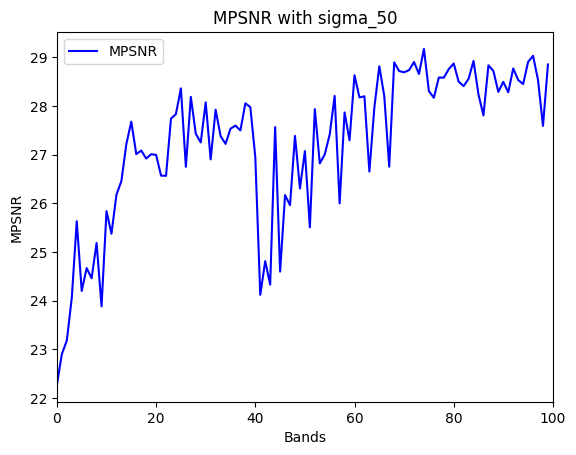

In [ ]:
epochs = range(0, n_epoch)
plt.plot(epochs, psnrs_matric, 'b', label='MPSNR')
plt.title(f'MPSNR with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MPSNR')
plt.legend()
plt.xlim(0,n_epoch)
plt.savefig(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_Graph_MPSNR_{argument_sigma_role}.png')
plt.show()

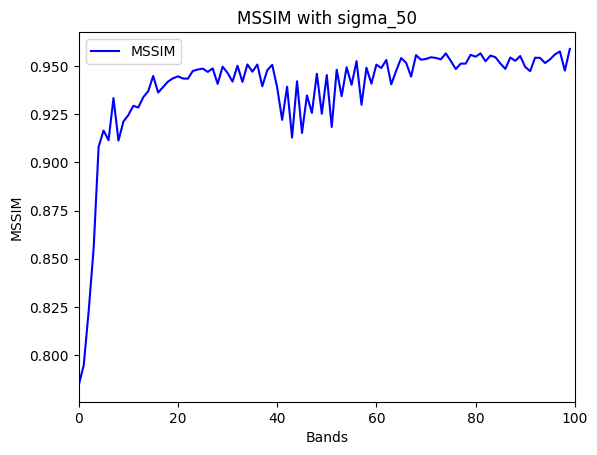

In [ ]:
epochs = range(0, n_epoch)
plt.plot(epochs, ssims_matric, 'b', label='MSSIM')
plt.title(f'MSSIM with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MSSIM')
plt.legend()
plt.xlim(0,n_epoch)
plt.savefig(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_Graph_MSSIM_{argument_sigma_role}.png')
plt.show()

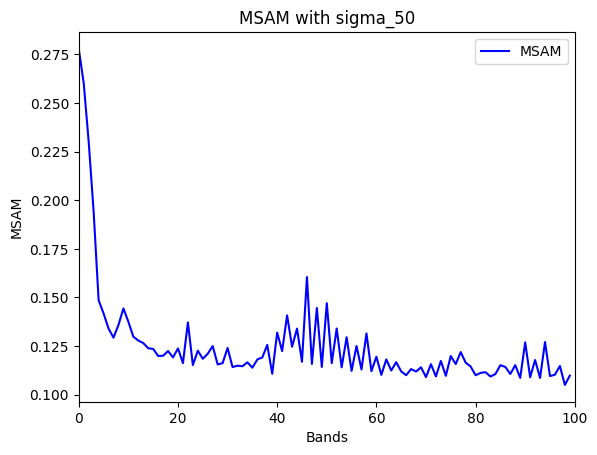

In [ ]:
epochs = range(0, n_epoch)
plt.plot(epochs, sams_matric, 'b', label='MSAM')
plt.title(f'MSAM with {argument_sigma_role}')
plt.xlabel('Bands')
plt.ylabel('MSAM')
plt.legend()
plt.xlim(0,n_epoch)
plt.savefig(f'./AAFEHDN_Denoising_{argument_sigma_role}/AAFEHDN_Denoising_Graph_MSAM_{argument_sigma_role}.png')
plt.show()

## Image Prediction

In the context of image prediction, we visually depict the Clean, Noise, and Denoise Hyperspectral Imaging (HSI) dataset using Matplotlib's image plotting service. This representation in the form of figures provides a clear and intuitive visualization of the data, allowing us to analyze and compare the different states of the HSI dataset, namely the clean images, the noisy versions, and the denoised counterparts. This visual approach helps researchers and analysts gain valuable insights into the dataset and the effectiveness of denoising techniques, contributing to a better understanding of hyperspectral image processing.

In [ ]:
SEED()

def show_image(data_noise,test_out,data_clean):
  def Noise_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(data_noise[:, :, (56,25,16)])
    plt.savefig(f"./AAFEHDN_Denoising_{argument_sigma_role}/Washington DC Mall University_Noise_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('noise image')
  def Denoise_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(test_out[:, :, (56,25,16)])
    plt.savefig(f"./AAFEHDN_Denoising_{argument_sigma_role}/Washington DC Mall University_Denoise_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('denoise image')
  def Clean_Image():
    fig = plt.figure(frameon=False, figsize = (5, 5))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    fig.add_axes(ax)
    plt.imshow(data_clean[:, :, (56,25,16)])
    plt.savefig(f"./AAFEHDN_Denoising_{argument_sigma_role}/Washington DC Mall University_Clean_{argument_sigma_role}.png")
    plt.axis('off')
    plt.title('clean image')

  Noise_Image()
  Denoise_Image()
  Clean_Image()
  plt.show()

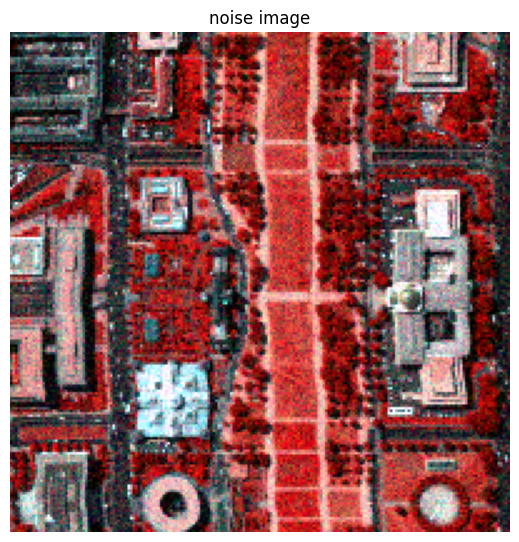

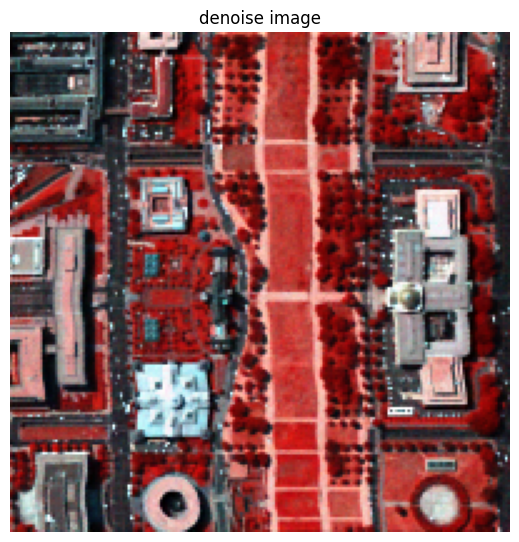

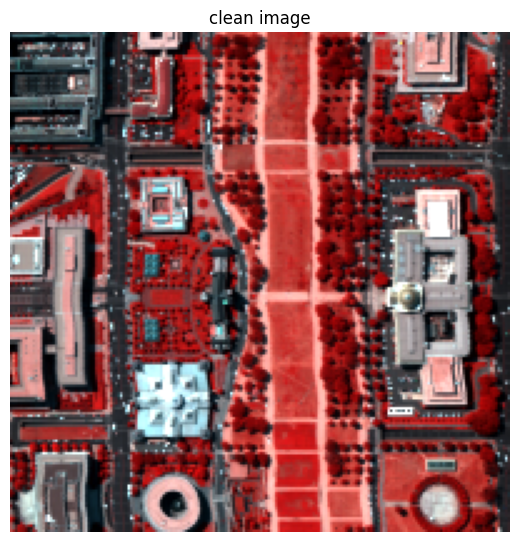

In [ ]:
show_image(test_data_noise_DC,denoise_image_out,test_data_clean_DC)

In [ ]:
SEED()

scipy.io.savemat(f"./AAFEHDN_Denoising_{argument_sigma_role}/Washington DC Mall University_Denoise_{argument_sigma_role}_Dataset_Image.mat",{'Image': denoise_image_out})